# Pytrans examples: a surface trap

This example shows how to generate a basic quadratic potential.

The model used here is SufaceTrap, as an example of a trap model defined from analytical functions. It uses a subset of the eletrodes of the LioniX surface trap used in Cryo (2020 - 2022). 

In [2]:
%reload_ext autoreload
%autoreload 2


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from functools import partial

In [4]:
from pytrans import objectives as obj
from pytrans.solver import solver

from pytrans.analysis import analyse_potential
from models.surface_trap.plot import plot_voltages_on_trap

from pytrans.ions import Ca40, Be9, elementary_charge
from pytrans.conversion import freq_to_curv



Loading interpolators: 100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


In [5]:
from models.surface_trap import SurfaceTrap
trap = SurfaceTrap()

r0 = (0, 0, 70e-6)

# Analyse the pseudopotential

--------------
Analyse curvatures along trajectory: 


100%|██████████| 21/21 [00:02<00:00,  7.92it/s]


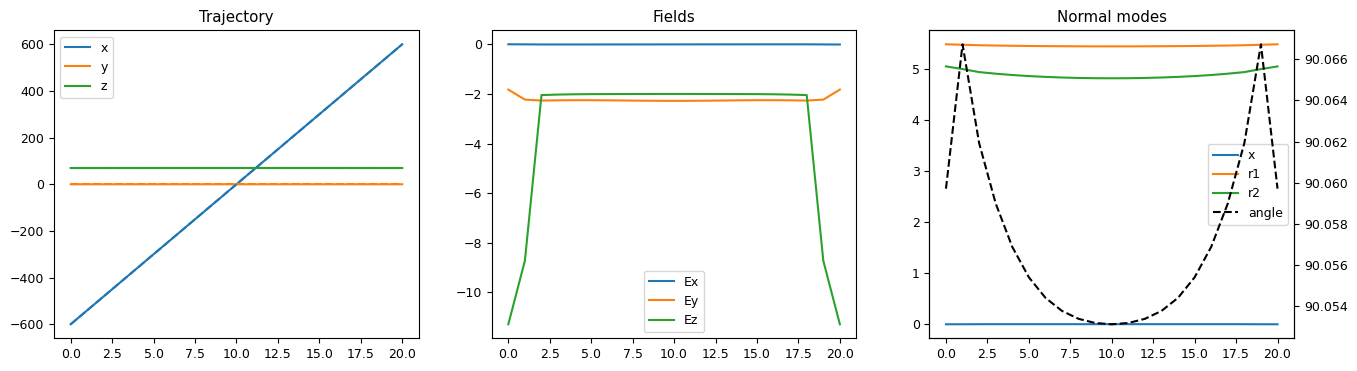

In [29]:
ion = Ca40

HH = trap.pseudo_hessian(*r0, ion.mass_amu)
from pytrans.analysis import analyse_fields_curvatures

_ = analyse_fields_curvatures(trap, ion=ion, voltages=np.zeros((trap.n_electrodes,)), find_3dmin=True, x=trap.x[::120])

--------------
Analyse potential: 
Exec minimize
- minimize elapsed time: 96.814 ms
Potential mimimum [um]
[-2.26367070e-02 -5.06959816e-03  7.13939783e+01]
Gradient [V/m]
[-0.0746866  -2.23137633 -5.16125772]
Hessian [V/m2]
[[ 3.29930196e+06  1.64426767e-01 -4.76268857e+02]
 [ 1.64426767e-01  4.40144527e+08  9.84655434e+04]
 [-4.76268857e+02  9.84655434e+04  3.61454251e+08]]
Normal mode frequencies for Ca40 [MHz]
[0.449195 5.18826 4.70165]
Eigenvectors
[[1 -9.88e-10 -1.33e-06]
 [-6.76e-10 1 -0.00125]
 [1.33e-06 0.00125 1]]
Tilt angle of mode 2 (4.70): 90.07°

--------------
Analyse potential: 
Exec minimize
- minimize elapsed time: 34.487 ms
Potential mimimum [um]
[-2.52043270e-02 -5.79040555e-03  7.01585027e+01]
Gradient [V/m]
[ -0.08249805 -12.20241803 -15.42021716]
Hessian [V/m2]
[[ 3.27310848e+06  2.15976030e-01 -5.79933618e+02]
 [ 2.15976030e-01  2.10732989e+09  5.26216075e+05]
 [-5.79933618e+02  5.26216075e+05  2.48253171e+09]]
Normal mode frequencies for Be9 [MHz]
[0.942151 23.

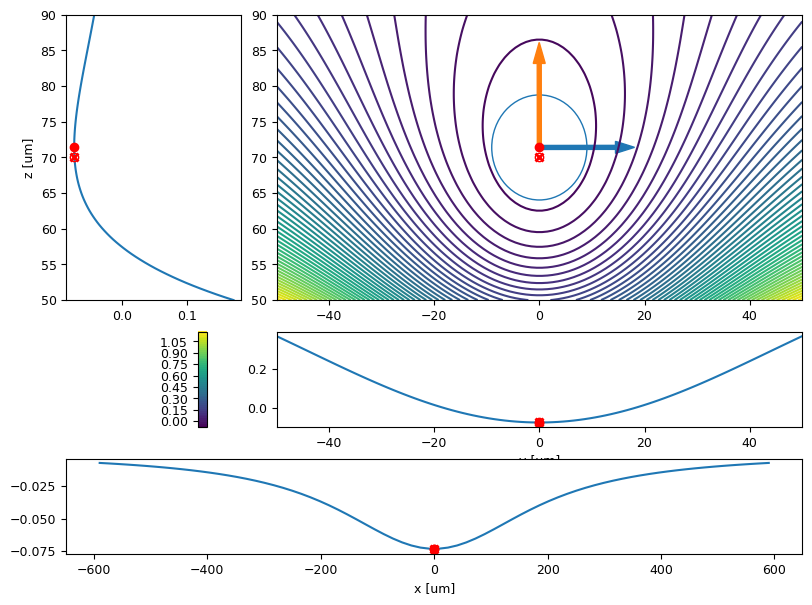

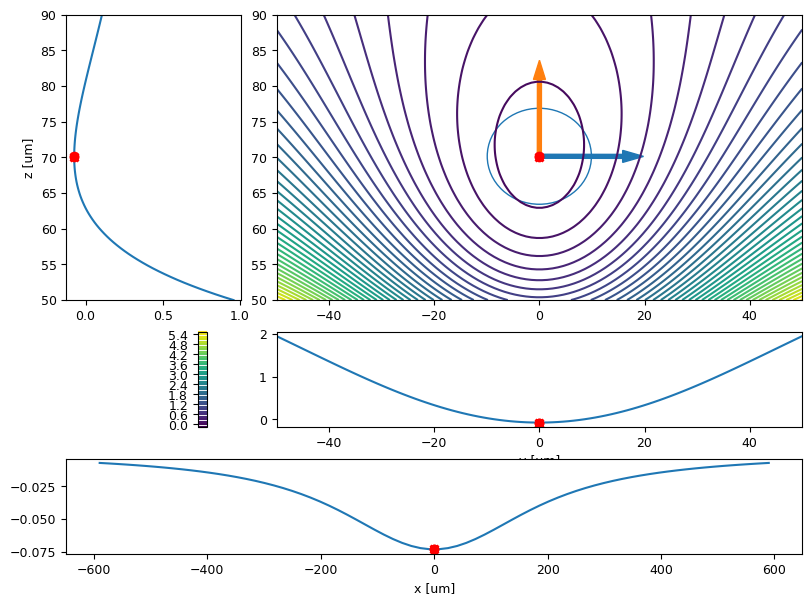

In [6]:
trap1 = SurfaceTrap(use_electrodes=["DCtop3", "DCbot3"])

res = analyse_potential(trap1, ion=Ca40, voltages=[-1, -1], r0=(0, 0, 70e-6), pseudo=True, find_3dmin=True, roi=(800, 50, 20))
res = analyse_potential(trap1, ion=Be9, voltages=[-1, -1], r0=(0, 0, 70e-6), pseudo=True, find_3dmin=True, roi=(800, 50, 20))


## Let's fit the usual quadratic potential

In [7]:
import cvxpy as cx

In [87]:
trap = SurfaceTrap()
ion = Ca40
# trap.v_rf = 40
# trap.rf_freq = 20
# trap.ion = Ca40

freq = 1e6
x0 = trap.x_ele(2)
y0 = 0
z0 = 70e-6

# offset = -2
# TRICK: leave the offset to the optimizer by defining it as a Variable
offset = cx.Variable()
offset.value = 0

R = 20e-6
dx = 2e-6
x = np.arange(-R, R + dx, dx) + x0
curv = freq_to_curv(freq, ion=ion)
pot = 0.5 * curv * (x - x0)**2 + offset

# len(step_opjectives) == number of steps == number of samples in the final waveform
# each element is a list of minimization objectives for that step
step_objectives = [
    [
        # obj.PotentialObjective(x, y=0, z=trap.z0, pseudo=False, value=pot),
        obj.GradientObjective(x0, y=0, z=trap.z0, pseudo=False, value=0),
        obj.HessianObjective(x0, y=0, z=trap.z0, pseudo=False, value=curv, entries='xx'),
        obj.HessianObjective(x0, y=0, z=trap.z0, pseudo=False, value=5e7, entries='yz'),
    ]
]

global_objectives = [
    obj.VoltageObjective(10, constraint_type='<='),
    obj.VoltageObjective(-10, constraint_type='>=')
]

# extra_constraints = [
#     offset >= -0.3
# ]
extra_constraints = None
waveform, final_costs = solver(trap, step_objectives, global_objectives, extra_constraints, verbose=False)
print(waveform[0].shape, waveform[0].value)
pprint(final_costs)

voltages = waveform.value
print(voltages.shape)

voltages = voltages[0]  # let's just take the one sample
print(voltages.shape)

r0 = (x0, y0, z0)
res = analyse_potential(trap, voltages, ion, r0, find_3dmin=True, minimize_options=dict(accuracy=1e-8), plot=False)
# _pot = 0.5 * curv * (x - x0)**2 + offset.value
# res['axes'][0].plot(x * 1e6, _pot)

# _ = plot_voltages_on_trap(trap, voltages)

true_r1 = np.asarray([-1.64997678e+02,  2.35686706e-02,  6.97796418e+01]) * 1e-6
shift = np.linalg.norm(res['shift'])

r1 = res['r1']
print(np.allclose(r1, true_r1, atol=1e-7, rtol=1e-3))
print(np.abs(shift) < 1e-7)



(12,) [-1.03680679  0.19411571  2.10824776 -3.40701046  1.88571987  0.73699269
 -0.12520335  0.91544312 -5.0391288   0.59976997  0.60904511  0.12365927]
[]
(1, 12)
(12,)
--------------
Analyse potential for ion Ca40: 
Exec minimize
- minimize elapsed time: 101.882 ms
Potential mimimum [um]
[-1.65009504e+02  2.47266165e-02  6.97754568e+01]
Gradient [V/m]
[-0.19333151  0.33292563 -1.53617971]
Displacement at 1 MHz [um]
[-0.01182362  0.02036081 -0.09394852]
Hessian [V/m2]
[[1.63278824e+07 1.66541753e+05 1.29629750e+05]
 [1.66541753e+05 4.69680725e+08 4.99154378e+07]
 [1.29629750e+05 4.99154378e+07 3.80982718e+08]]
Normal mode frequencies [MHz]
[0.999281 5.48595 4.6828]
Eigenvectors
[[1 -0.000431 0.000146]
 [-0.000333 -0.912 -0.41]
 [-0.00031 -0.41 0.912]]
Tilt angle of mode 2 (4.68): 114.19°

True
True


In [80]:
np.linalg.norm(res['shift']) * 1e6

1.2623703295803228e-05

## Benchmark analysis

100%|██████████| 21/21 [00:02<00:00,  9.62it/s]


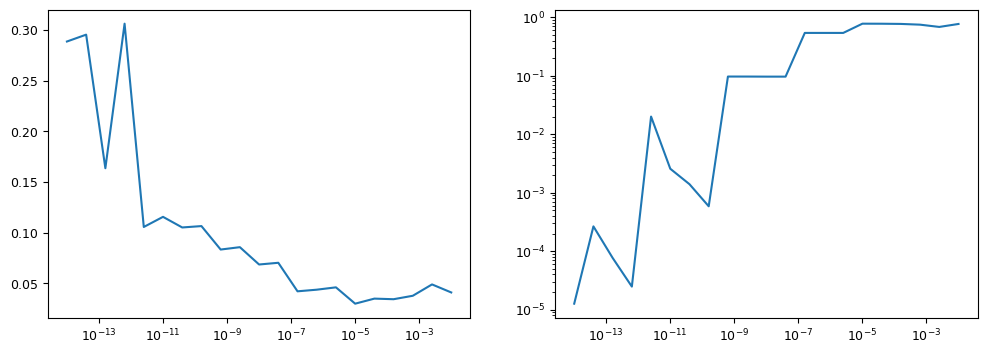

In [79]:
import time
from tqdm import tqdm
acc = np.logspace(-2, -14, 21, base=10)

times = []
shifts = []

for ac in tqdm(acc):
    ts = time.time()
    res = analyse_potential(trap, voltages, ion, r0, find_3dmin=True, minimize_options=dict(accuracy=ac), plot=False, verbose=False)
    te = time.time()
    times.append(te - ts)
    shifts.append(np.linalg.norm(res['shift']))
    

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

ax.semilogx(acc, times)
ax1.loglog(acc, np.asarray(shifts) * 1e6)

In [58]:
r1 = res['r1']
np.allclose(r1, r0, atol=1e-7, rtol=1e-2)

True

In [42]:
np.abs(r1 - r0) * 1e6

array([0.05744356, 0.00993746, 0.23249952])

In [9]:
voltages

array([-1.03680679,  0.19411571,  2.10824776, -3.40701046,  1.88571987,
        0.73699269, -0.12520335,  0.91544312, -5.0391288 ,  0.59976997,
        0.60904511,  0.12365927])

## Fit 3D
Here I'd like to build the ellipsoid that has the axial and radial curvatures that I want.
Without radial mode rotation (a.k.a. tilt) is easy. I do think it's possible also with tilt but not quite sure how now.

(12,) [ 1.15848737  5.8388371   9.99999928  9.99999973  8.09431534  9.99999973
  9.99999928  6.36799907  9.99999947 -1.89551984  9.99999947  6.36799907]
[]
--------------
Analyse potential: 
Exec minimize
- minimize elapsed time: 88.011 ms
Potential mimimum [um]
[-5.77746009e-02  2.46784620e+00  6.43726581e+01]
Gradient [V/m]
[-0.76093131  7.20563892 -8.84712912]
Hessian [V/m2]
[[ 1.31697218e+07  1.54586215e+04 -4.11692472e+03]
 [ 1.54586215e+04  3.89263278e+08  2.07759153e+08]
 [-4.11692472e+03  2.07759153e+08  1.26117934e+09]]
Normal mode frequencies for Ca40 [MHz]
[0.897454 4.57531 8.94444]
Eigenvectors
[[1 -4.86e-05 -4.68e-07]
 [-4.73e-05 -0.975 0.221]
 [1.12e-05 0.221 0.975]]
Tilt angle of mode 2 (8.94): 77.26°



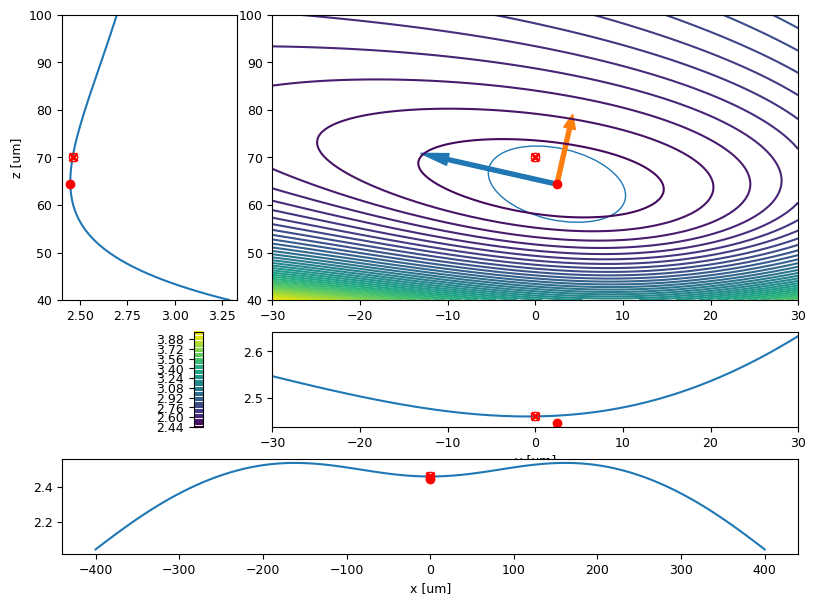

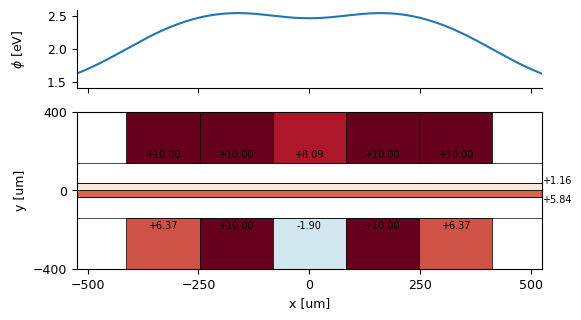

In [9]:
# I'll just guess some frequencies that I know are reasonable for this trap, since it's basically a subset of the Cryo one
axial = freq_to_curv(1e6)
r1 = freq_to_curv(3.5e6)
r2 = freq_to_curv(6.5e6)


x0 = 0

# TRICK: leave the offset floating by letting the optimizer vary it
offset = cx.Variable()
offset.value = 0
# offset = 0

x = np.arange(-30, 32, 4) * 1e-6
y = np.arange(-20, 21, 2) * 1e-6
z = np.arange(-20, 21, 2) * 1e-6  # don't put z0 here

curv = np.diag([axial, r1, r2])  # .astype(object)

# rtilt = cx.Variable()
# rtilt.value = freq_to_curv(2e6)
rtilt = 2e8
curv[1, 2] = curv[2, 1] = rtilt

# There must be a more elegant way than meshgrid + ravel + stack
# But it works so let's go for it
R = np.meshgrid(x, y, z, indexing='ij')  # First axis is X, Y, Z. please always use ij with 3d data
R = np.stack(list(map(np.ravel, R)), axis=0)
X, Y, Z = R

pot = 0.5 * np.diag(R.T @ curv @ R) + offset
pot.shape


# len(step_opjectives) == number of steps == number of samples in the final waveform
# each element is a list of minimization objectives for that step
step_objectives = [
    [obj.PotentialObjective(X, Y, Z + trap.z0, pot)]
]

global_objectives = [
    obj.VoltageObjective(10, constraint_type='<='),
    obj.VoltageObjective(-10, constraint_type='>=')
]

# extra_constraints = [
#     r2 >= freq_to_curv(2e6)
# ]
extra_constraints = None
waveform, final_costs = solver(trap, step_objectives, global_objectives, extra_constraints, verbose=False)
print(waveform[0].shape, waveform[0].value)
pprint(final_costs)

voltages = waveform.value[0]  # let's just take the one sample

res = analyse_potential(trap, voltages, (x0, y0, z0))
_ = plot_voltages_on_trap(trap, voltages)


# Opt hessian matrix

(12,) [-1.11625355 -0.03521078  4.20577918 -5.85776323  3.83775178  1.70181094
  0.54395971 -1.99667903 -3.09347942 -1.6024985  -1.95310221 -0.08176222]
[]
--------------
Analyse potential: 
Exec minimize
- minimize elapsed time: 317.594 ms
Potential mimimum [um]
[-1.65000003e+02 -4.28176527e-07  6.99999995e+01]
Gradient [V/m]
[-0.00004303 -0.00023122 -0.00019096]
Hessian [V/m2]
[[ 1.63513799e+07 -6.36378095e-01 -5.05831087e+04]
 [-6.36378095e-01  4.79807201e+08  5.00000104e+07]
 [-5.05831087e+04  5.00000104e+07  3.29816105e+08]]
Normal mode frequencies for Ca40 [MHz]
[1 5.50178 4.38688]
Eigenvectors
[[1 3.06e-05 0.000162]
 [-1.77e-05 -0.957 0.29]
 [0.000164 -0.29 -0.957]]
Tilt angle of mode 2 (4.39): 106.85°



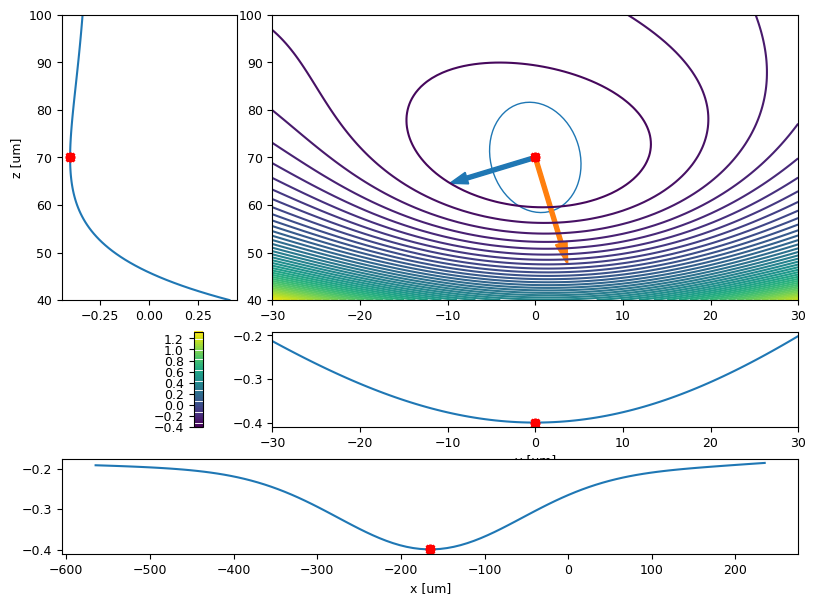

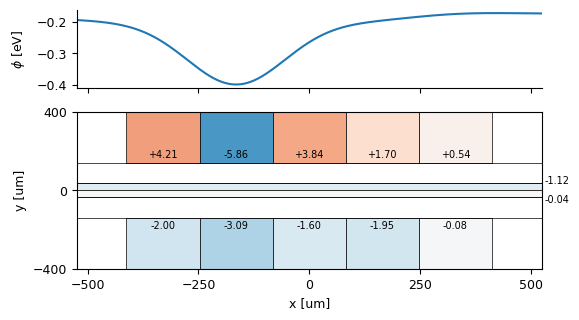

In [10]:
# I'll just guess some frequencies that I know are reasonable for this trap, since it's basically a subset of the Cryo one
axial = freq_to_curv(1e6)
# r1 = freq_to_curv(3.5e6)
# r2 = freq_to_curv(6.5e6)
r1 = -axial / 2
r2 = -axial / 2 

x0 = trap.x_ele(2)

curv = np.diag([axial, r1, r2])  # .astype(object)

# rtilt = cx.Variable()
# rtilt.value = freq_to_curv(2e6)
rtilt = 5e7
curv[1, 2] = curv[2, 1] = rtilt



# len(step_opjectives) == number of steps == number of samples in the final waveform
# each element is a list of minimization objectives for that step
step_objectives = [
    [
        obj.GradientObjective(x0, y0, z0, 0),
        # obj.HessianObjective(x0, y0, z0, axial, entries=["xx"]),
        # obj.HessianObjective(x0, y0, z0, rtilt, entries=["yz"]),
        obj.HessianObjective(x0, y0, z0, curv.ravel(), pseudo=False),
    ]
]
# for dx in [20e-6, 50e-6, 100e-6]:
#     step_objectives[0].extend(
#         [
#             obj.HessianObjective(x0 + dx, y0, z0, axial, entries=["xx"]),
#             obj.HessianObjective(x0 - dx, y0, z0, axial, entries=["xx"]),
#         ]
#     )

global_objectives = [
    obj.VoltageObjective(10, constraint_type='<='),
    obj.VoltageObjective(-10, constraint_type='>=')
]

# extra_constraints = [
#     r2 >= freq_to_curv(2e6)
# ]
extra_constraints = None
waveform, final_costs = solver(trap, step_objectives, global_objectives, extra_constraints, verbose=False)
print(waveform[0].shape, waveform[0].value)
pprint(final_costs)

voltages = waveform.value[0]  # let's just take the one sample


res = analyse_potential(trap, voltages, (x0, y0, z0))
_ = plot_voltages_on_trap(trap, voltages)


In [24]:
x = np.asarray([0, 1])
y = np.asarray([2, 3])

np.outer(x, y)

array([[0, 0],
       [2, 3]])

In [12]:
a = np.ones((2, 4))

aa = np.ones(10)

In [13]:
e1 = np.asarray([a, a, a])
e2 = np.stack([a, a, a], axis=-1)

e1.shape, e2.shape

((3, 2, 4), (2, 4, 3))

In [14]:
h1 = np.asarray([[a, a, a], [a, a, a], [a, a, a]])
h2 = h1.transpose(tuple(_ for _ in range(2, h1.ndim)) + (0, 1))
h1.shape, h2.shape

((3, 3, 2, 4), (2, 4, 3, 3))

In [15]:
tuple(_ for _ in range(2, h1.ndim)) + (0, 1)


(2, 3, 0, 1)

In [16]:
a.ndim

2

In [17]:
from models.surface_trap.data.analytic import hessiansDC

In [18]:
# Compute hessians in a 2d plane


x = 0
y = np.linspace(-20, 21, 4) * 1e-6
z = np.linspace(-20, 21, 6) * 1e-6  + 70e-6

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
X.shape

(1, 4, 6)

In [19]:
HH = hessiansDC.DCtop3(X, Y, Z)

In [20]:
HH.shape

(1, 4, 6, 3, 3)

In [21]:
trap = SurfaceTrap()

HHint = trap.electrode_moment("DCtop3", X, Y, Z, d=2)

In [22]:
abs(HH).min()

0.0

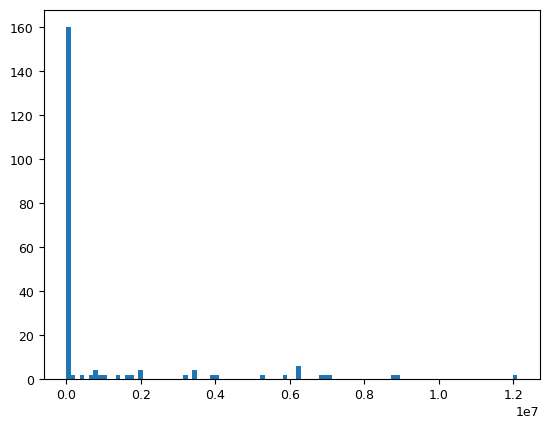

In [23]:
rdiff = (abs(HH - HHint) / np.maximum(abs(HH), 1e-12)).ravel()

_ = plt.hist(rdiff, 100)


In [24]:
np.allclose(hessiansDC.DCtop3(*r0), trap.electrode_moment("DCtop3", *r0, d=2), rtol=1)


True